# Train CNN with MFCCs


Inspired by https://medium.com/@diego-rios/speech-emotion-recognition-with-convolutional-neural-network-ae5406a1c0f7

MFCC tensors with repetitive padding


Import the necessary libraries


In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchview import draw_graph
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import os
import sys
import numpy as np
import random
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.1.1+cu118
True


Set the seed for reproducibility


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
MODEL = 'cnn_mfccs_repetitive'

train_csv = '../../../data/mfcc_train_dataset.csv'
test_csv = '../../../data/mfcc_test_dataset.csv'
val_csv = '../../../data/mfcc_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Custom dataset class for loading the mfcc tensors


In [6]:
from datasets.MfccDataset import MFCCDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="Training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the validation function


In [8]:
def validate(model, valloader, criterion, device):
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    # Switch to evaluation mode
    model.eval()

    epoch_start = time.time()
    pbar = tqdm(enumerate(valloader), total=len(
        valloader), desc="Validating")

    with torch.no_grad():
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate time metrics
            elapsed = time.time() - epoch_start
            progress = (i + 1) / len(valloader)
            eta = elapsed / progress - elapsed

            # Update progress bar with current loss and ETA
            pbar.set_postfix({
                "Loss": f"{loss.item()}",
                "Elapsed": f"{elapsed:.4f}s",
                "ETA": f"{eta:.4f}s"
            })

    val_loss = val_loss / len(valloader)
    val_accuracy = val_correct / val_total * 100

    return val_loss, val_accuracy

Import EarlyStopping class


In [9]:
from models.EarlyStopping import EarlyStopping

Define what happens in each epoch


In [10]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0

    early_stopper = EarlyStopping(path=f'earlystop_{MODEL}.pt')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(
            model, valloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(
            f'Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Save best validation accuracy model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, f'best_{MODEL}_checkpoint.pt')

        # Check for early stopping (based on val_loss)
        early_stopper(val_loss, model)
        if early_stopper.early_stop:
            break

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Plot the loss and accuracy graphs


In [11]:
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [12]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(val_accuracies)),
             val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Import the model


In [13]:
from CNNMFCCs import CNNMFCCs

model = CNNMFCCs()

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNNMFCCs(
  (conv1): Conv1d(40, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=22016, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=9, bias=True)
)

Visualize the model


In [14]:
summary(model, (40, 172))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 172]           1,936
            Conv1d-2              [-1, 32, 172]           1,568
            Conv1d-3              [-1, 64, 172]           6,208
            Conv1d-4             [-1, 128, 172]          24,704
           Dropout-5             [-1, 128, 172]               0
            Linear-6                  [-1, 128]       2,818,176
           Dropout-7                  [-1, 128]               0
            Linear-8                   [-1, 64]           8,256
            Linear-9                    [-1, 9]             585
Total params: 2,861,433
Trainable params: 2,861,433
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.49
Params size (MB): 10.92
Estimated Total Size (MB): 11.43
-------------------------------------

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [15]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([])

epochs = 100

Execute the training


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 62.26it/s, Loss=1.417786955833435, Elapsed=1.3978s, ETA=0.0000s] 


Epoch 1 completed in 6.8548s
Train Loss: 1.4266837053216261 - Train Accuracy: 36.60704190316818
Validation Loss: 1.2201254733403524 - Validation Accuracy: 46.90797804981005

Epoch 2/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 68.77it/s, Loss=1.494863748550415, Elapsed=1.2717s, ETA=0.0000s] 


Epoch 2 completed in 6.4061s
Train Loss: 1.1526332247808488 - Train Accuracy: 47.665136473621125
Validation Loss: 1.1012040877342224 - Validation Accuracy: 49.841705360911774

Epoch 3/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 63.12it/s, Loss=1.253705620765686, Elapsed=1.3686s, ETA=0.0000s] 


Epoch 3 completed in 6.5030s
Train Loss: 1.0501794482586702 - Train Accuracy: 52.002442278555435
Validation Loss: 1.0258735958735148 - Validation Accuracy: 54.474461798227104

Epoch 4/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 64.99it/s, Loss=1.320861577987671, Elapsed=1.3101s, ETA=0.0000s] 


Epoch 4 completed in 6.2732s
Train Loss: 0.9869516209370828 - Train Accuracy: 54.734176070192895
Validation Loss: 1.0111934439341228 - Validation Accuracy: 53.85183621781342

Epoch 5/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 64.30it/s, Loss=1.475543737411499, Elapsed=1.3291s, ETA=0.0000s] 


Epoch 5 completed in 6.5389s
Train Loss: 0.9414168561814148 - Train Accuracy: 56.690260283575675
Validation Loss: 0.9745823629697163 - Validation Accuracy: 56.69058674546223

Epoch 6/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 71.19it/s, Loss=1.2779157161712646, Elapsed=1.2315s, ETA=0.0000s]


Epoch 6 completed in 6.5166s
Train Loss: 0.900363299543458 - Train Accuracy: 58.44734402207096
Validation Loss: 0.9624861264228821 - Validation Accuracy: 57.387083157450405

Epoch 7/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 65.64it/s, Loss=1.515766978263855, Elapsed=1.3089s, ETA=0.0000s] 


Epoch 7 completed in 6.4175s
Train Loss: 0.8630219930513746 - Train Accuracy: 59.84939282241469
Validation Loss: 0.978254607518514 - Validation Accuracy: 58.22076825664837

EarlyStopping counter: 1/5
Epoch 8/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 66.57it/s, Loss=1.2214428186416626, Elapsed=1.3217s, ETA=0.0000s]


Epoch 8 completed in 6.3898s
Train Loss: 0.8209634536952641 - Train Accuracy: 61.430089776350606
Validation Loss: 0.9602353779474894 - Validation Accuracy: 58.17855635289152

Epoch 9/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 62.09it/s, Loss=1.4636294841766357, Elapsed=1.3907s, ETA=0.0000s]

Epoch 9 completed in 6.4143s
Train Loss: 0.7871761607985965 - Train Accuracy: 62.74394518441464
Validation Loss: 0.9619878538449605 - Validation Accuracy: 57.58758970029548

EarlyStopping counter: 1/5
Epoch 10/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.44it/s, Loss=1.32888925075531, Elapsed=1.2871s, ETA=0.0000s]  


Epoch 10 completed in 6.6384s
Train Loss: 0.7510621535640232 - Train Accuracy: 64.34725582867868
Validation Loss: 0.9652595853805542 - Validation Accuracy: 60.13085690164627

EarlyStopping counter: 2/5
Epoch 11/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 65.40it/s, Loss=1.2861268520355225, Elapsed=1.3054s, ETA=0.0000s]


Epoch 11 completed in 6.7661s
Train Loss: 0.7125826591701176 - Train Accuracy: 65.84202075936773
Validation Loss: 0.9626270270347596 - Validation Accuracy: 60.510764035457996

EarlyStopping counter: 3/5
Epoch 12/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 59.54it/s, Loss=1.4597972631454468, Elapsed=1.4360s, ETA=0.0000s]

Epoch 12 completed in 6.5671s
Train Loss: 0.6822367290713195 - Train Accuracy: 67.38427443974582
Validation Loss: 0.9752311118443807 - Validation Accuracy: 60.50021105951878

EarlyStopping counter: 4/5
Epoch 13/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 64.11it/s, Loss=1.666507363319397, Elapsed=1.3338s, ETA=0.0000s] 


Epoch 13 completed in 6.5880s
Train Loss: 0.6444876510972921 - Train Accuracy: 68.56697044390674
Validation Loss: 1.0203737926483154 - Validation Accuracy: 61.059518784297175

EarlyStopping counter: 5/5
🔁 Early stopping triggered!


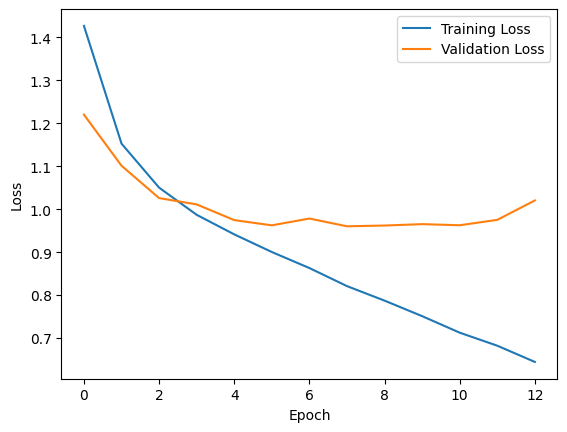

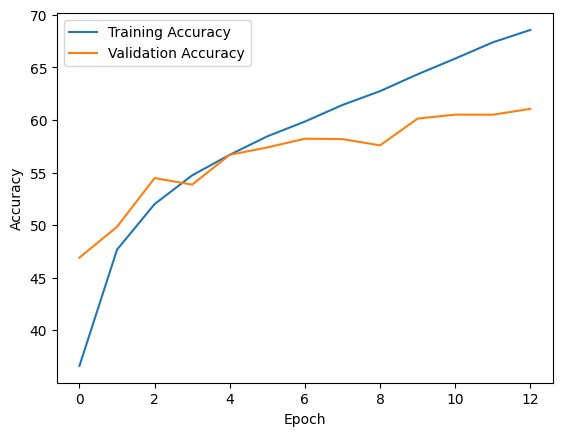

In [16]:
trainset = MFCCDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MFCCDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MFCCDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

Define the function to plot the confusion matrix


In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to evaluate best model on test set


In [18]:
def get_predictions(model, testloader, device, model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []
    print("Evaluating best model on test set...")

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

Define the function to print out the evaluation metrics


In [19]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report


def get_evaluation_metrics(true_labels, pred_labels, label_map):
    # Compute metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-score: {f1:.4f}\n")

    # Print detailed classification report
    print(classification_report(true_labels, pred_labels,
          target_names=list(label_map.keys())))

Evaluate the best model on the test set


Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:01<00:00, 52.57it/s]


Test Accuracy: 0.6091
Test Precision: 0.6405
Test Recall: 0.6091
Test F1-score: 0.6097

              precision    recall  f1-score   support

       Anger       0.57      0.76      0.65       916
       Bored       0.61      0.84      0.70      1098
     Disgust       0.37      0.55      0.44       291
        Fear       0.29      0.72      0.41       308
       Happy       0.71      0.46      0.56      1914
     Neutral       0.62      0.48      0.54      2226
    Question       0.80      0.67      0.73      1139
         Sad       0.64      0.64      0.64       857
    Surprise       0.68      0.70      0.69       728

    accuracy                           0.61      9477
   macro avg       0.59      0.65      0.60      9477
weighted avg       0.64      0.61      0.61      9477



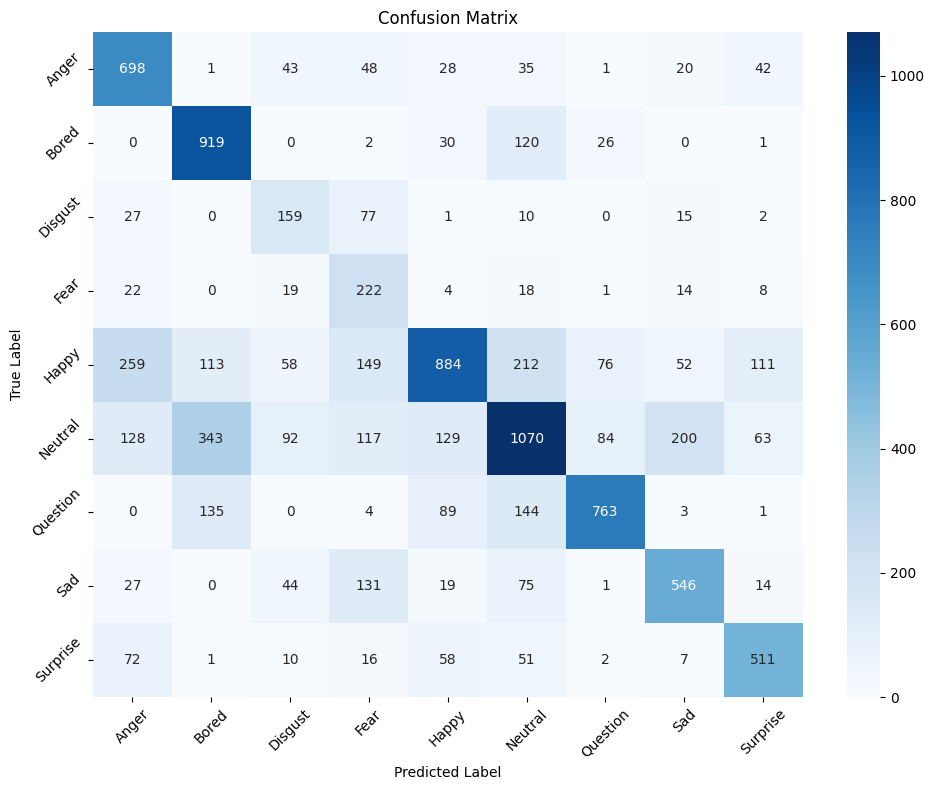

In [20]:
# Load and get predictions from the bets model
best_model_path = f'best_{MODEL}.pt'
all_preds, all_labels = get_predictions(
    model=model,
    testloader=testloader,
    device=device,
    model_path=best_model_path
)

# Print detailed evaluation metrics
get_evaluation_metrics(all_labels, all_preds, labelmap)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)